# Proyecto 1 - Analítica de textos

## Etapa 1 - Construcción de modelos de analítica de textos

**Integrantes:**
- Estudiante 1: Daniela Echavarria Yepes - 202111348
- Estudiante 2: Diego Alejandro Molano Roa - 202123015
- Estudiante 3: Juan Manuel Rodriguez Diaz - 202013372


# Introducción y objetivo



## Importación de librerías

In [70]:
!pip install wordcloud nltk spacy

In [71]:
!pip install --upgrade --force-reinstall "spacy<3.8" "thinc<9.1"

  Using cached spacy-3.7.5.tar.gz (1.3 MB)
  Installing build dependencies: started
  Installing build dependencies: still running...
  Installing build dependencies: finished with status 'error'


  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> [166 lines of output]
      Ignoring numpy: markers 'python_version < "3.9"' don't match your environment
        Using cached setuptools-80.9.0-py3-none-any.whl.metadata (6.6 kB)
        Using cached Cython-0.29.37-py2.py3-none-any.whl.metadata (3.1 kB)
        Using cached cymem-2.0.11-cp313-cp313-win_amd64.whl.metadata (8.8 kB)
        Using cached preshed-3.0.10-cp313-cp313-win_amd64.whl.metadata (2.5 kB)
        Using cached murmurhash-1.0.13-cp313-cp313-win_amd64.whl.metadata (2.2 kB)
        Using cached thinc-8.2.5.tar.gz (193 kB)
        Installing build dependencies: started
        Installing build dependencies: finished with status 'error'
        error: subprocess-exited-with-error
      
        × pip subprocess to install build dependencies did not run successfully.
        │ exit code: 1
        ╰─> [136 lines of output]
            

### Para lematización (2.3): Descargar modelo de lenguaje en español

In [72]:
!python -m spacy download es_core_news_sm

     ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
      --------------------------------------- 0.3/12.9 MB ? eta -:--:--
     - -------------------------------------- 0.5/12.9 MB 1.5 MB/s eta 0:00:09
     --- ------------------------------------ 1.0/12.9 MB 2.3 MB/s eta 0:00:06
     ----- ---------------------------------- 1.8/12.9 MB 2.6 MB/s eta 0:00:05
     ------- -------------------------------- 2.4/12.9 MB 2.6 MB/s eta 0:00:05
     -------- ------------------------------- 2.9/12.9 MB 2.6 MB/s eta 0:00:04
     ---------- ----------------------------- 3.4/12.9 MB 2.6 MB/s eta 0:00:04
     ------------- -------------------------- 4.2/12.9 MB 2.7 MB/s eta 0:00:04
     --------------- ------------------------ 5.0/12.9 MB 2.8 MB/s eta 0:00:03
     ----------------- ---------------------- 5.8/12.9 MB 2.9 MB/s eta 0:00:03
     ------------------- -------------------- 6.3/12.9 MB 2.9 MB/s eta 0:00:03
     --------------------- ------------------ 7.1/12.9 MB 2.9 MB/s

In [73]:
# ====================================
# 1. Importación de librerías
# ====================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from joblib import dump, load
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import (mean_absolute_error,
                            mean_squared_error,
                            r2_score,
                            confusion_matrix,
                            classification_report,
                            precision_score,
                            recall_score,
                            f1_score,
                            accuracy_score, 
                            ConfusionMatrixDisplay)
# Para crear el arbol de decisión
from sklearn.tree import DecisionTreeClassifier
# Para usar KNN como clasificador
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import scipy.stats as stats

from sklearn import tree
#import sklearn as sklearn

import unicodedata
import re

from wordcloud import WordCloud
import nltk
import spacy

# Configuración
pd.set_option("display.max_columns", None)
sns.set(style="whitegrid")


# Carga de datos

In [74]:
# ====================================
# 2. Carga de datos
# ====================================
df = pd.read_excel("Datos_proyecto.xlsx")
print(f"Filas y columnas: {df.shape}")
display(df.head())
print("Ejemplo de texto: " + df["textos"].iloc[0])  # Ejemplo de texto

Filas y columnas: (2424, 2)


,textos,labels
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4
1,Para los niños más pequeños (bebés y niños peq...,4
2,"Además, la formación de especialistas en medic...",3
3,En los países de la OCDE se tiende a pasar de ...,4
4,Este grupo se centró en las personas que padec...,3


Ejemplo de texto: "Aprendizaje" y "educación" se consideran sinónimos de escolarización formal. Las organizaciones auxiliares, como las editoriales de educación, las juntas examinadoras y las organizaciones de formación de docentes, se consideran extensiones de los acuerdos establecidos por los gobiernos. Este marco de comprensión se ha vuelto cada vez más inadecuado.


# 1. Entendimiento inicial de los datos

## 1.1 Distribución de la longitud de filas

In [75]:
df["longitud"] = df["textos"].str.len()
df["longitud"].describe()

count    2424.000000
mean      683.223185
std       223.563695
min       303.000000
25%       513.000000
50%       647.000000
75%       809.250000
max      1492.000000
Name: longitud, dtype: float64

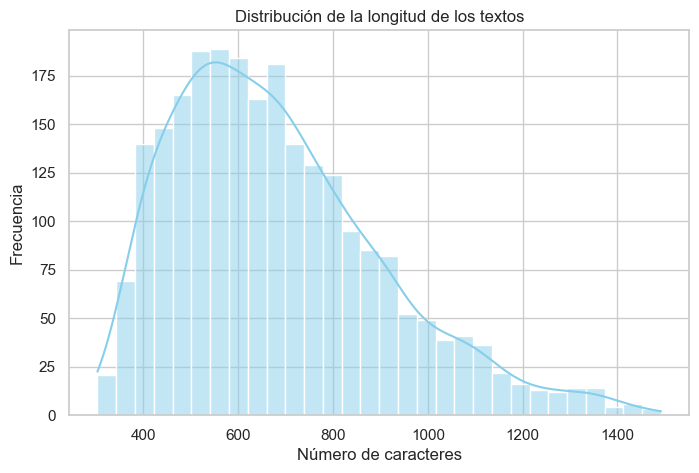

In [76]:
plt.figure(figsize=(8,5))
sns.histplot(df["longitud"], bins=30, kde=True, color="skyblue")
plt.title("Distribución de la longitud de los textos")
plt.xlabel("Número de caracteres")
plt.ylabel("Frecuencia")
plt.show()

## 1.2 Distribución de la variable objetivo

Observamos el balance de clases para el atributo "labels".

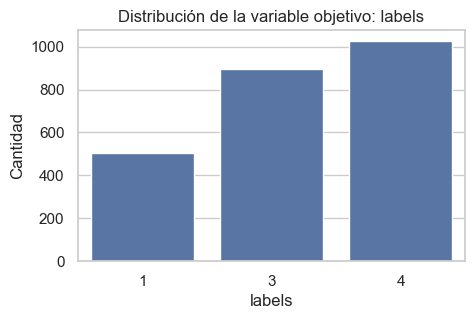

In [77]:
plt.figure(figsize=(5,3))
sns.countplot(data=df, x='labels')
plt.title('Distribución de la variable objetivo: labels')
plt.ylabel('Cantidad')
plt.show()

# 2. Limpieza y preparación de datos

In [78]:
df = df.drop_duplicates(subset="textos")
print(df.shape)

(2424, 3)


In [79]:
df = df.dropna(subset=["textos", "labels"])
print(df.shape)

(2424, 3)


## 2.1 Normalización

1. Pasar todo a minúsculas
2. Eliminar acentos
3. Eliminar caractéres especiales
4. Eliminar espacios adicionales

In [80]:
n_norm = 0

def normalize_text(text):
    if not isinstance(text, str):
        return ""
    
    text = text.lower()  # Pasar a minúsculas
    text = unicodedata.normalize('NFD', text)
    text = text.encode('ascii', 'ignore').decode("utf-8")  # Eliminar acentos
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Eliminar caracteres especiales
    text = re.sub(r'\s+', ' ', text).strip() # Eliminar espacios extra
    return text

df["textos"] = df["textos"].apply(normalize_text)

print("Ejemplo de normalizacion: " + df["textos"].iloc[0])  # Ejemplo de texto normalizado

Ejemplo de normalizacion: aprendizaje y educacion se consideran sinonimos de escolarizacion formal las organizaciones auxiliares como las editoriales de educacion las juntas examinadoras y las organizaciones de formacion de docentes se consideran extensiones de los acuerdos establecidos por los gobiernos este marco de comprension se ha vuelto cada vez mas inadecuado


## 2.2 Tokenización

In [81]:
import nltk
from nltk.corpus import stopwords

# Descargar stopwords
nltk.download("stopwords")

stop_words = set(stopwords.words("spanish"))
print(len(stop_words), "stopwords cargadas")
for i in range(int(len(stop_words)/10) + 1):
    print(list(stop_words)[i*10:(i+1)*10])
#print(stop_words)

313 stopwords cargadas
['os', 'hubimos', 'sean', 'él', 'ella', 'ni', 'entre', 'estarás', 'sí', 'habidas']
['quien', 'todo', 'tanto', 'tenías', 'les', 'tendrías', 'eso', 'antes', 'estén', 'tuvieran']
['las', 'están', 'mucho', 'fue', 'mi', 'teníais', 'ha', 'habían', 'como', 'estuvieseis']
['hubieron', 'le', 'estuvieras', 'habidos', 'tú', 'estaríamos', 'tengáis', 'serás', 'todos', 'fueron']
['estuviesen', 'seas', 'nosotros', 'vuestro', 'tiene', 'hubieras', 'este', 'seré', 'un', 'fuésemos']
['nuestros', 'sentidos', 'tuvieron', 'son', 'somos', 'hubisteis', 'tuyo', 'fuera', 'estando', 'fueran']
['fuesen', 'fuimos', 'tuvieras', 'otro', 'serían', 'tendríamos', 'estuvierais', 'tus', 'fueses', 'con']
['estaré', 'tenía', 'míos', 'seréis', 'estuvieron', 'tuve', 'tendríais', 'tenemos', 'tuvisteis', 'estaréis']
['tuviste', 'mis', 'tienen', 'quienes', 'otra', 'tendrá', 'teniendo', 'sois', 'suyas', 'mías']
['tuvierais', 'una', 'algunas', 'tuvieseis', 'estado', 'eran', 'fuiste', 'sentidas', 'de', 'habr

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\diego\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [82]:
def remove_stopwords(text):
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

df["textos_limpios"] = df["textos"].apply(remove_stopwords)

print("Ejemplo de texto limpio: " + df["textos_limpios"].iloc[0])  # Ejemplo de texto limpio

Ejemplo de texto limpio: aprendizaje educacion consideran sinonimos escolarizacion formal organizaciones auxiliares editoriales educacion juntas examinadoras organizaciones formacion docentes consideran extensiones acuerdos establecidos gobiernos marco comprension vuelto cada vez mas inadecuado


## 2.3 Lematización

Opcional.

In [83]:
import spacy
from tqdm import tqdm

# Carga del modelo en español
nlp = spacy.load("es_core_news_sm")

def lemmatize_text(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct])

# Aplica a la columna de texto limpio que ya tienes (ajusta el nombre si difiere)
tqdm.pandas()  # barra de progreso
df["texto_lema"] = df["textos"].astype(str).progress_apply(lemmatize_text)

df[["textos", "texto_lema"]].head(10)

print("Ejemplo de texto lema: " + df["texto_lema"].iloc[0])  # Ejemplo de texto limpio


100%|██████████| 2424/2424 [00:52<00:00, 46.05it/s]

Ejemplo de texto lema: aprendizaje educacion considerar sinonimo escolarizacion formal organización auxiliar editorial educacion junto examinadora organización formacion docente considerar extensión acuerdo establecido gobierno marco comprension volver inadecuado


## 2.4 Visualización palabras más repetidas

In [84]:
from collections import Counter

all_text = " ".join(df["texto_lema"])
tokens = all_text.split()

# Contar frecuencia de cada palabra
word_freq = Counter(tokens)

# Mostrar las 20 más comunes
for palabra, freq in word_freq.most_common(20):
    print(f"{palabra}: {freq}")


salud: 1107
pobreza: 1018
educacion: 992
país: 962
escuela: 913
atencion: 900
estudiante: 774
nivel: 730
ano: 713
sistema: 713
él: 681
servicio: 620
ocde: 585
programa: 533
ingreso: 524
tasa: 522
nino: 521
docente: 500
resultado: 495
persona: 493


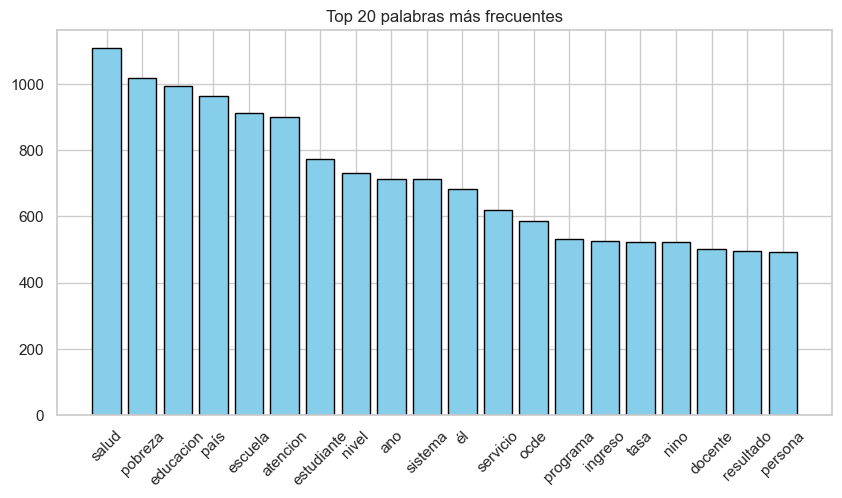

In [85]:
# Convertir a DataFrame
freq_df = pd.DataFrame(word_freq.most_common(20), columns=["Palabra", "Frecuencia"])

# Gráfico de barras
plt.figure(figsize=(10,5))
plt.bar(freq_df["Palabra"], freq_df["Frecuencia"], color="skyblue", edgecolor="black")
plt.xticks(rotation=45)
plt.title("Top 20 palabras más frecuentes")
plt.show()


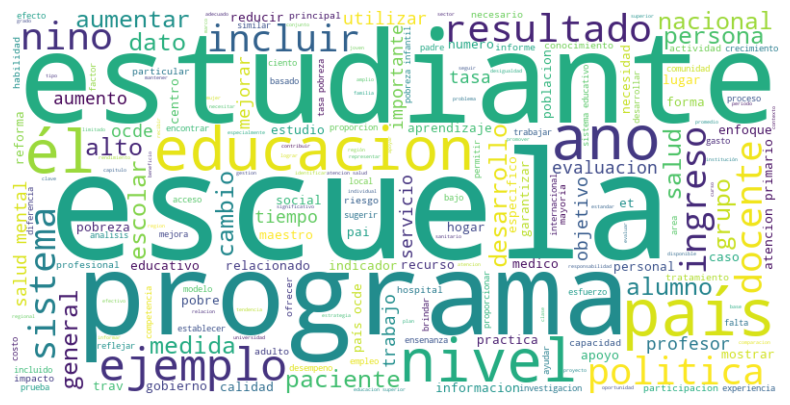

In [86]:

all_text = " ".join(df["texto_lema"])
wc = WordCloud(width=800, height=400, background_color="white").generate(all_text)

plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()


# 3. División train/test

In [87]:
from sklearn.model_selection import train_test_split

# Definimos X (features) e y (target)
X = df["texto_lema"]     # textos ya lematizados
y = df["labels"]         # AJUSTA si tu columna de clase tiene otro nombre

# División estratificada para balancear las clases
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,       # 80% train, 20% test
    random_state=42,
    stratify=y           # mantiene la proporción de las clases
)

print("Tamaño total:", len(df))
print("Train:", len(X_train))
print("Test :", len(X_test))
print("\nDistribución de clases en train:")
print(y_train.value_counts(normalize=True).round(3))
print("\nDistribución de clases en test:")
print(y_test.value_counts(normalize=True).round(3))


Tamaño total: 2424
Train: 1939
Test : 485

Distribución de clases en train:
labels
4    0.423
3    0.369
1    0.208
Name: proportion, dtype: float64

Distribución de clases en test:
labels
4    0.423
3    0.369
1    0.208
Name: proportion, dtype: float64


## 3.1 Vectorización con TF-IDF

In [88]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    ngram_range=(1,2),
    max_features=20000,
    min_df=2,
    max_df=0.95,
    sublinear_tf=True,
    norm="l2"
)

X_train_tfidf = vectorizer.fit_transform(X_train)  # SOLO fit en train
X_test_tfidf  = vectorizer.transform(X_test)       # transform en test

print("Shape train:", X_train_tfidf.shape, " | Shape test:", X_test_tfidf.shape)
print("Vocabulario:", len(vectorizer.get_feature_names_out()))


Shape train: (1939, 13611)  | Shape test: (485, 13611)
Vocabulario: 13611


In [89]:
import pandas as pd

# Selecciona el primer documento
doc_index = 0

# Obtiene el vector (como array denso)
vector = X_train_tfidf[doc_index].toarray()[0]

# Crea un DataFrame para ver las palabras con valores > 0
df_vector = pd.DataFrame({
    "termino": vectorizer.get_feature_names_out(),
    "tfidf": vector
})

# Filtra solo las palabras que aparecen en el documento
df_vector = df_vector[df_vector["tfidf"] > 0].sort_values("tfidf", ascending=False)

print("Texto original:\n", X_train.iloc[doc_index])
print("\nRepresentación TF-IDF (top 15 términos):")
display(df_vector.head(15))


Texto original:
 letonia mover direccion plan desarrollo atencion primario salud esforzar mejorar calidad accesibilidad servicio salud mejorar actividad preventivo evitar persona recibir atencion hospitalario costoso letonia demostrar utilizar fuerza laboral innovadoro mejorar acceso atencion primario necesitar fortalecer papel desempenir medico cabecera profesional salud promocion salud particular educar paciente autocontrol enfermedad cronica seccion 31 describir estructura sistema atencion primaria salud letonia fuerza laboral desafio

Representación TF-IDF (top 15 términos):


,termino,tfidf
7635,letonia,0.244025
6061,fuerza laboral,0.191748
6059,fuerza,0.179747
4335,educar,0.154429
11913,salud promocion,0.154429
5528,evitar persona,0.154429
5262,estructura sistema,0.154429
12002,seccion 31,0.148483
3636,desarrollo atencion,0.148483
664,actividad preventivo,0.148483


## 3.2 Guardar el vectorizador

In [90]:
from joblib import dump
dump(vectorizer, "tfidf_vectorizer.joblib")
print("Vectorizador guardado en tfidf_vectorizer.joblib")


Vectorizador guardado en tfidf_vectorizer.joblib


## 3.3 Checks rápidos de calidad
Opcional

In [91]:
import numpy as np

# Densidad (sparsity): valores no-cero / total
train_density = X_train_tfidf.nnz / (X_train_tfidf.shape[0] * X_train_tfidf.shape[1])
test_density  = X_test_tfidf.nnz  / (X_test_tfidf.shape[0]  * X_test_tfidf.shape[1])

print(f"Densidad train: {train_density:.4f}  | Densidad test: {test_density:.4f}")

# Echar un vistazo a algunos términos
terms = vectorizer.get_feature_names_out()
print("Ejemplos de términos:", terms[:30])


Densidad train: 0.0040  | Densidad test: 0.0036
Ejemplos de términos: ['000' '000 estudiante' '000 habitante' '000 persona' '01' '02' '03' '04'
 '048' '05' '06' '07' '07 punto' '071' '08' '09' '10' '10 000' '10 abril'
 '10 ano' '10 ciento' '10 mostrar' '10 país' '100' '100 000' '100 hora'
 '1000' '1000 habitante' '10000' '101']


# 4. Entrenamiento de modelos

# Logistic Regression

Estudiante 1: Daniela Echavarria

La Logistic Regression es un clasificador lineal que modela la probabilidad de cada clase a partir de una combinación lineal de las características: en binario aplica una sigmoide sobre el puntaje y en multiclase usa softmax, entrenando por entropía cruzada con regularización (L2/L1) para evitar sobreajuste. En clasificación de texto suele ser una excelente elección porque funciona especialmente bien con representaciones dispersas y de alta dimensión como TF-IDF de unigramas/bigramas, es rápida y estable incluso con miles de atributos, ofrece probabilidades útiles para ajustar umbrales, y es interpretable: sus coeficientes permiten identificar qué términos empujan la predicción hacia cada clase. Además, con multi_class="multinomial" maneja naturalmente varios temas/categorías, requiere poca ingeniería de características y sirve como baseline fuerte que a menudo compite con modelos más complejos en texto.

In [92]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Modelo base (ajusta max_iter para asegurar convergencia)
logreg = LogisticRegression(
    penalty="l2",
    C=1.0,
    class_weight=None,   # pon "balanced" si tienes desbalance de clases
    solver="lbfgs",      # para L2; usa "liblinear" o "saga" si quieres L1
    max_iter=2000,
    n_jobs=None
)

# Entrenar
logreg.fit(X_train_tfidf, y_train)

# Predecir
y_pred = logreg.predict(X_test_tfidf)



Accuracy: 0.9628865979381444

Reporte de clasificación:
               precision    recall  f1-score   support

           1      0.968     0.911     0.939       101
           3      0.956     0.966     0.961       179
           4      0.967     0.985     0.976       205

    accuracy                          0.963       485
   macro avg      0.964     0.954     0.959       485
weighted avg      0.963     0.963     0.963       485

F1 macro: 0.9586


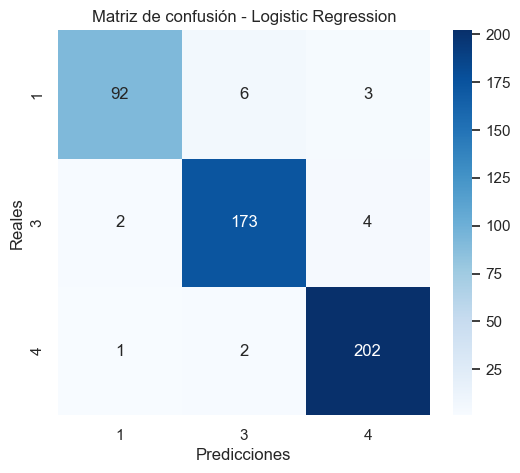

In [93]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nReporte de clasificación:\n", classification_report(y_test, y_pred, digits=3))

cm = confusion_matrix(y_test, y_pred)

f1_macro = round(f1_score(y_test, y_pred, average="macro"), 4)
print("F1 macro:", f1_macro)

plt.figure(figsize=(6,5))
sns.heatmap(cm,
            annot=True,          # muestra los números
            fmt="d",             # formato enteros
            cmap="Blues",        # paleta de colores
            xticklabels=logreg.classes_,  # nombres de clases en eje X
            yticklabels=logreg.classes_)  # nombres de clases en eje Y
plt.xlabel("Predicciones")
plt.ylabel("Reales")
plt.title("Matriz de confusión - Logistic Regression")
plt.show()

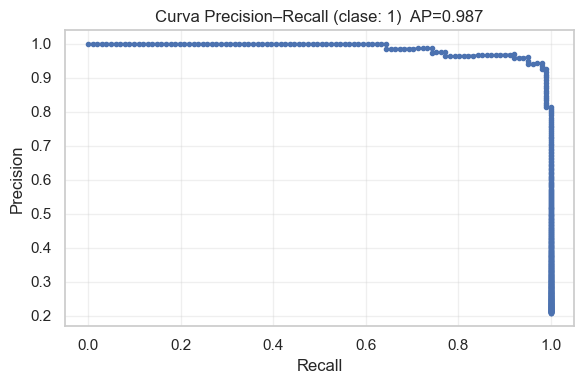

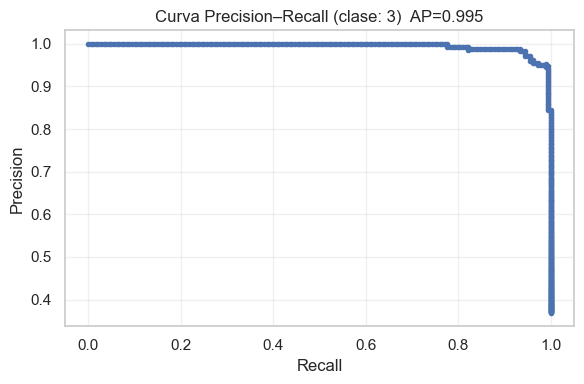

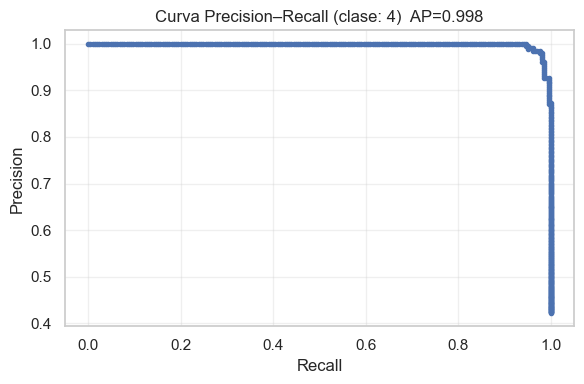

In [94]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, average_precision_score

# --- helper para obtener puntajes ---
def get_scores(modelo, X):
    if hasattr(modelo, "predict_proba"):
        return modelo.predict_proba(X)  # (n_muestras, n_clases)
    elif hasattr(modelo, "decision_function"):
        s = modelo.decision_function(X)
        return s if s.ndim > 1 else s.reshape(-1, 1)
    else:
        raise ValueError("El modelo no expone predict_proba ni decision_function.")

# Usa la X que tengas disponible
X_eval = X_test_tfidf if 'X_test_tfidf' in globals() else X_test

classes = logreg.classes_
y_score = get_scores(logreg, X_eval)
y_bin   = label_binarize(y_test, classes=classes)

# --- una curva por clase ---
for i, cls in enumerate(classes):
    # si en y_true no hay positivos para esa clase, no se puede trazar PR
    if y_bin[:, i].sum() == 0:
        print(f"Clase {cls}: no hay positivos en y_test; se omite.")
        continue

    p, r, _ = precision_recall_curve(y_bin[:, i], y_score[:, i])
    ap = average_precision_score(y_bin[:, i], y_score[:, i])

    plt.figure(figsize=(6,4))
    plt.plot(r, p, marker='.')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Curva Precision–Recall (clase: {cls})  AP={ap:.3f}")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # (opcional) guardar a archivo:
    # plt.savefig(f"pr_{str(cls).replace(' ', '_')}.png", dpi=120)
    # plt.close()



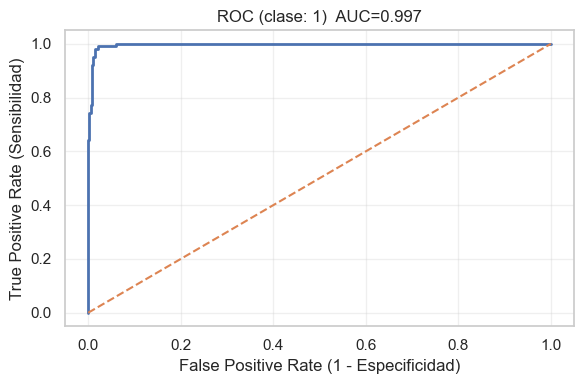

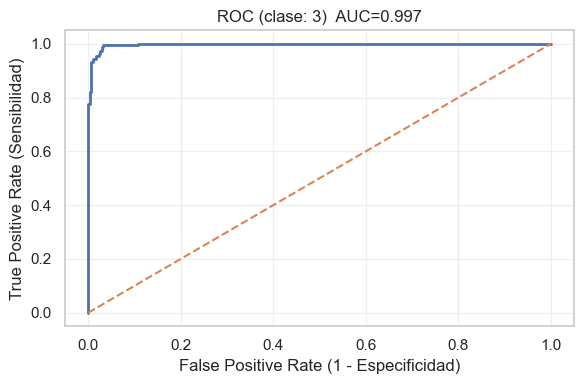

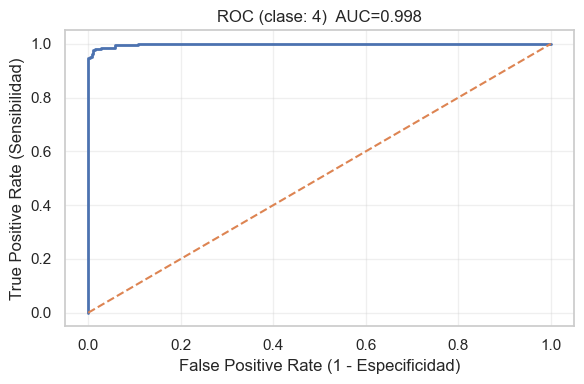

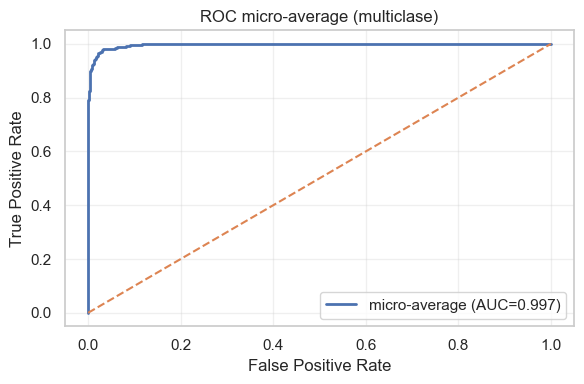

AUC por clase:
  1: 0.9969
  3: 0.9971
  4: 0.9985

AUC micro: 0.9967
AUC macro: 0.9975


In [95]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
# Elige la X correcta
X_eval = X_test_tfidf if 'X_test_tfidf' in globals() else X_test

classes = logreg.classes_
y_score = get_scores(logreg, X_eval)              # (n_muestras, n_clases)
y_bin   = label_binarize(y_test, classes=classes)  # one-vs-rest

# ROC por clase
aucs = []
for i, cls in enumerate(classes):
    # si no hay positivos para esa clase en y_val, se omite
    if y_bin[:, i].sum() == 0:
        print(f"Clase {cls}: no hay positivos en y_test; se omite la curva.")
        continue

    fpr, tpr, _ = roc_curve(y_bin[:, i], y_score[:, i])
    auc_i = auc(fpr, tpr)
    aucs.append((cls, auc_i))

    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, linewidth=2)
    plt.plot([0,1], [0,1], linestyle="--")  # referencia azar
    plt.xlabel("False Positive Rate (1 - Especificidad)")
    plt.ylabel("True Positive Rate (Sensibilidad)")
    plt.title(f"ROC (clase: {cls})  AUC={auc_i:.3f}")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Micro-average (todas las clases combinadas)
fpr_micro, tpr_micro, _ = roc_curve(y_bin.ravel(), y_score.ravel())
auc_micro = auc(fpr_micro, tpr_micro)

plt.figure(figsize=(6,4))
plt.plot(fpr_micro, tpr_micro, linewidth=2, label=f"micro-average (AUC={auc_micro:.3f})")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC micro-average (multiclase)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Macro AUC (promedio simple de AUC por clase)
if aucs:
    auc_macro = np.mean([v for _, v in aucs])
    print("AUC por clase:")
    for cls, v in aucs:
        print(f"  {cls}: {v:.4f}")
    print(f"\nAUC micro: {auc_micro:.4f}")
    print(f"AUC macro: {auc_macro:.4f}")


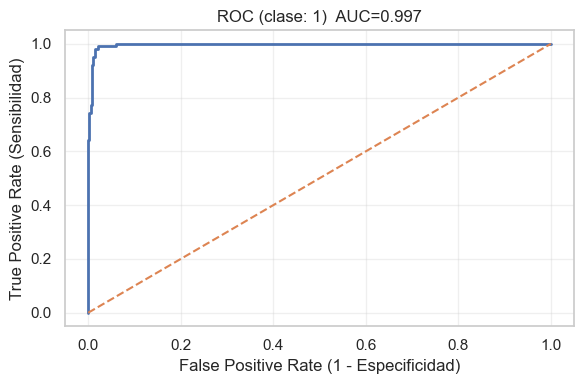

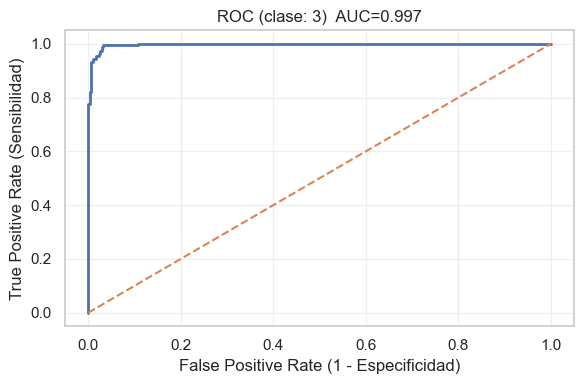

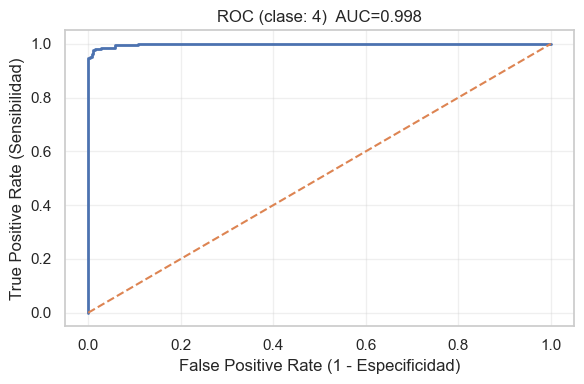

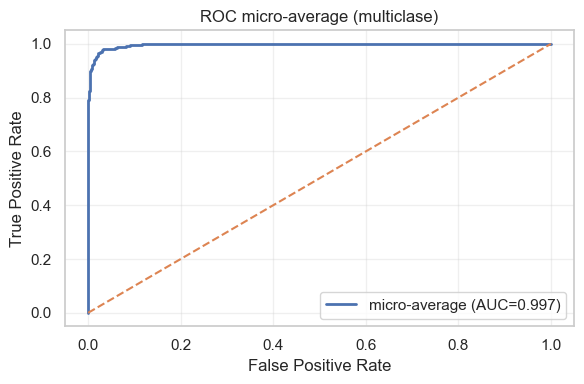

AUC por clase:
  1: 0.9969
  3: 0.9971
  4: 0.9985

AUC micro: 0.9967
AUC macro: 0.9975


In [96]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
# Elige la X correcta
X_eval = X_test_tfidf if 'X_test_tfidf' in globals() else X_test

classes = logreg.classes_
y_score = get_scores(logreg, X_eval)              # (n_muestras, n_clases)
y_bin   = label_binarize(y_test, classes=classes)  # one-vs-rest

# ROC por clase
aucs = []
for i, cls in enumerate(classes):
    # si no hay positivos para esa clase en y_val, se omite
    if y_bin[:, i].sum() == 0:
        print(f"Clase {cls}: no hay positivos en y_test; se omite la curva.")
        continue

    fpr, tpr, _ = roc_curve(y_bin[:, i], y_score[:, i])
    auc_i = auc(fpr, tpr)
    aucs.append((cls, auc_i))

    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, linewidth=2)
    plt.plot([0,1], [0,1], linestyle="--")  # referencia azar
    plt.xlabel("False Positive Rate (1 - Especificidad)")
    plt.ylabel("True Positive Rate (Sensibilidad)")
    plt.title(f"ROC (clase: {cls})  AUC={auc_i:.3f}")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Micro-average (todas las clases combinadas)
fpr_micro, tpr_micro, _ = roc_curve(y_bin.ravel(), y_score.ravel())
auc_micro = auc(fpr_micro, tpr_micro)

plt.figure(figsize=(6,4))
plt.plot(fpr_micro, tpr_micro, linewidth=2, label=f"micro-average (AUC={auc_micro:.3f})")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC micro-average (multiclase)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Macro AUC (promedio simple de AUC por clase)
if aucs:
    auc_macro = np.mean([v for _, v in aucs])
    print("AUC por clase:")
    for cls, v in aucs:
        print(f"  {cls}: {v:.4f}")
    print(f"\nAUC micro: {auc_micro:.4f}")
    print(f"AUC macro: {auc_macro:.4f}")


In [97]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1,2), min_df=3, max_df=0.9,
        sublinear_tf=True, norm="l2"
    )),
    ("clf", LogisticRegression(max_iter=2000, solver="lbfgs"))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# X = textos (ej. df["texto_lema"]), y = etiquetas (ej. df["labels"])
scores = cross_val_score(pipe, X, y, cv=cv, scoring="f1_macro", n_jobs=-1)
print("Scores por fold:", scores)
print("F1_macro promedio:", scores.mean(), "±", scores.std())


Scores por fold: [0.97185317 0.98373441 0.95686581 0.96623548 0.96919894]
F1_macro promedio: 0.9695775609225503 ± 0.008700531231377397


In [98]:
import numpy as np

feature_names = vectorizer.get_feature_names_out()
coefs = logreg.coef_

if coefs.shape[0] == 1:  # binario
    top_pos = np.argsort(coefs[0])[-15:][::-1]
    top_neg = np.argsort(coefs[0])[:15]
    print("\nTop + (clase positiva):")
    for i in top_pos: print(feature_names[i], coefs[0, i])
    print("\nTop - (clase negativa):")
    for i in top_neg: print(feature_names[i], coefs[0, i])
else:  # multiclase one-vs-rest
    for cls_idx in range(coefs.shape[0]):
        top = np.argsort(coefs[cls_idx])[-10:][::-1]
        print(f"\nClase {logreg.classes_[cls_idx]}: top términos")
        for i in top: print(feature_names[i], coefs[cls_idx, i])



Clase 1: top términos
pobreza 6.456383530155591
pobre 3.1084266119738606
hogar 2.2285514379969236
ingreso 2.221895930263369
social 1.5624531091951304
privacion 1.390460109203009
proteccion social 1.2840012107918652
proteccion 1.1636237258359277
transferencia 1.1356613140777665
nino 1.1301382408351768

Clase 3: top términos
salud 4.534914713268674
atencion 2.8203145225056776
medico 2.377174631754824
paciente 2.2957496017334384
enfermedad 2.1753550069534593
sanitario 2.01924046268497
mental 1.607968222159636
hospital 1.4516887425757996
tratamiento 1.415229771138765
servicio 1.4013348391479599

Clase 4: top términos
educacion 3.7055652510962203
escuela 3.5716392347437718
estudiante 3.1016666334254412
educativo 2.4755567494240056
docente 2.3694178044741396
aprendizaje 2.2663723698079012
escolar 2.146303590823714
alumno 2.025553002411001
profesor 1.6273823313168378
ensenanza 1.5597174236532518


El modelo muestra un desempeño sólido: la exactitud en el hold-out es de 0,963 y el F1-macro ronda 0,96. Las curvas ROC confirman una muy buena separabilidad, con AUC por clase entre 0,9968 y 0,9984 y promedios micro y macro cercanos a 0,997. Además, la validación cruzada estratificada (5-fold) arroja un F1-macro medio de ~0,969 con desviación estándar baja (~0,009), lo que sugiere estabilidad y buena capacidad de generalización.

El principal punto a vigilar es la clase 1, cuyo recall es 0,91: alrededor del 9 % de sus casos se confunden sobre todo con las clases 3 y 4. En contraste, las clases 3 y 4 presentan recalls de 0,97–0,99 y prácticamente no se confunden entre sí, lo que indica fronteras bien definidas para “salud” y “educación”.

Desde la interpretabilidad, los coeficientes de la regresión logística son coherentes con la semántica de cada categoría. En la clase 1 destacan términos como “pobreza”, “ingreso”, “privacion” y el bigrama “proteccion social”; en la clase 3 sobresalen “salud”, “medico”, “paciente” y “tratamiento”; y en la clase 4, “educacion”, “escuela”, “estudiante” y “docente”. La presencia de bigramas informativos confirma que el TF-IDF con n-gramas está capturando contexto útil.

# Naive Bayes

Estudiante 3: Juan Manuel Rodriguez

### Naive Bayes Multinomial

El Naive Bayes Multinomial es un clasificador probabilístico basado en el teorema de Bayes, que asume independencia condicional entre las características dado la clase. En el caso de texto, modela la probabilidad de un documento como el producto de las probabilidades de sus palabras, lo que lo hace especialmente adecuado para variables discretas como las frecuencias de términos o representaciones TF-IDF.  

Es muy eficiente: requiere poco tiempo de entrenamiento y memoria, lo que lo convierte en una excelente opción para conjuntos de datos grandes y de alta dimensionalidad. En clasificación de texto suele rendir bien porque, aunque la suposición de independencia entre términos es simplificadora y poco realista, en la práctica capta patrones útiles al distinguir categorías por las palabras más características.  

Además, expone las probabilidades por clase, lo que permite interpretar con claridad qué términos son más representativos de cada categoría. Su simplicidad lo hace robusto frente a sobreajuste, con pocos hiperparámetros (principalmente el suavizado de Laplace `α`), y ofrece una buena línea base: rápido de entrenar, fácil de explicar y competitivo frente a modelos más complejos, especialmente cuando los datos están balanceados y las señales semánticas en el vocabulario son claras.


In [99]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, f1_score
import matplotlib.pyplot as plt
import numpy as np

# Definir rango de valores para alpha (suavizado de Laplace)
param_grid = {"alpha": [0.1, 0.3, 0.5, 1.0, 2.0, 3.0]}

nb = MultinomialNB()
grid = GridSearchCV(
    nb, param_grid,
    scoring="f1_macro",
    cv=5, n_jobs=-1
)

grid.fit(X_train_tfidf, y_train)

best_nb = grid.best_estimator_
print("Mejor alpha encontrado:", grid.best_params_["alpha"])


Mejor alpha encontrado: 0.1


In [ ]:
# Predicciones
y_pred_nb = best_nb.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test, y_pred_nb))


# Reporte bonito en texto
print("\n=== Reporte en TEST (Naive Bayes) ===")
print(classification_report(y_test, y_pred_nb, digits=3))

# F1 macro (corregido)
f1_macro = round(f1_score(y_test, y_pred_nb, average="macro"), 4)
print("F1 macro:", f1_macro)

# Matriz de confusión
# Matriz de confusión
nb_matrix = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(6,5))
sns.heatmap(nb_matrix,
            annot=True,          # muestra los números
            fmt="d",             # formato enteros
            cmap="Blues",        # paleta de colores
            xticklabels=logreg.classes_,  # nombres de clases en eje X
            yticklabels=logreg.classes_)  # nombres de clases en eje Y
plt.xlabel("Predicciones")
plt.ylabel("Reales")
plt.title("Matriz de confusión — Naive Bayes")
plt.show()

# (Opcional) Reporte como dict -> DataFrame para tu informe
rep_dict = classification_report(y_test, y_pred_nb, output_dict=True)
rep_df = pd.DataFrame(rep_dict).T
display(rep_df.round(3))

Accuracy: 0.9649484536082474

=== Reporte en TEST (Naive Bayes) ===
              precision    recall  f1-score   support

           1      0.960     0.950     0.955       101
           3      0.941     0.978     0.959       179
           4      0.990     0.961     0.975       205

    accuracy                          0.965       485
   macro avg      0.964     0.963     0.963       485
weighted avg      0.966     0.965     0.965       485

F1 macro: 0.9631


ValueError: Must pass 2-d input. shape=()

<Figure size 600x500 with 0 Axes>

In [101]:
feat_names = vectorizer.get_feature_names_out()
topk = 15
top_terms = {}

for i, cls in enumerate(best_nb.classes_):
    idx = np.argsort(best_nb.feature_log_prob_[i])[::-1][:topk]
    top_terms[cls] = [feat_names[j] for j in idx]

from pprint import pprint
print("\n=== Top términos por clase (Naive Bayes) ===")
pprint(top_terms)



=== Top términos por clase (Naive Bayes) ===
{np.int64(1): ['pobreza',
               'pobre',
               'ingreso',
               'hogar',
               'nino',
               'país',
               'social',
               'tasa',
               'infantil',
               'persona',
               'tasa pobreza',
               'pobreza infantil',
               'crecimiento',
               'vivir',
               'reducir'],
 np.int64(3): ['salud',
               'atencion',
               'servicio',
               'paciente',
               'medico',
               'mental',
               'enfermedad',
               'sanitario',
               'país',
               'atencion primario',
               'salud mental',
               'sistema',
               'persona',
               'primario',
               'tratamiento'],
 np.int64(4): ['escuela',
               'educacion',
               'estudiante',
               'docente',
               'aprendizaje',
         

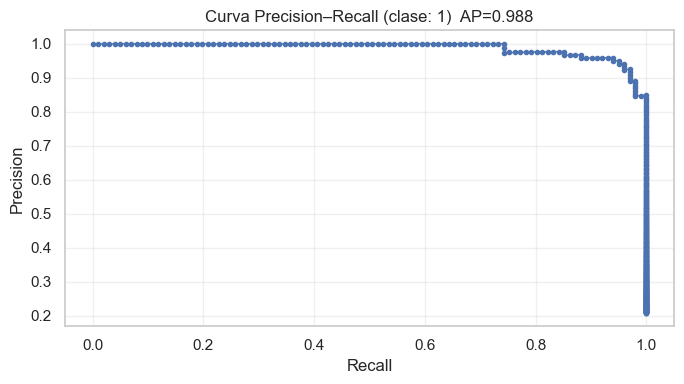

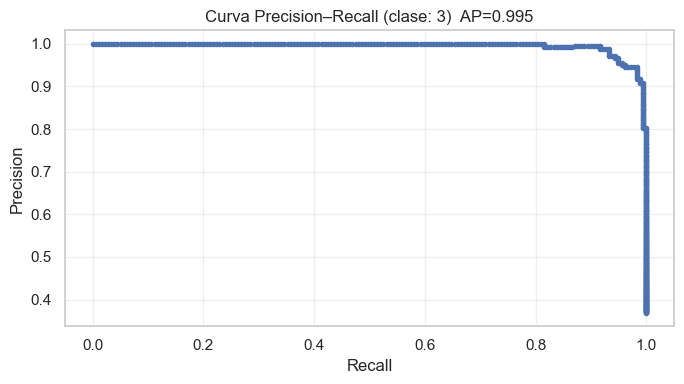

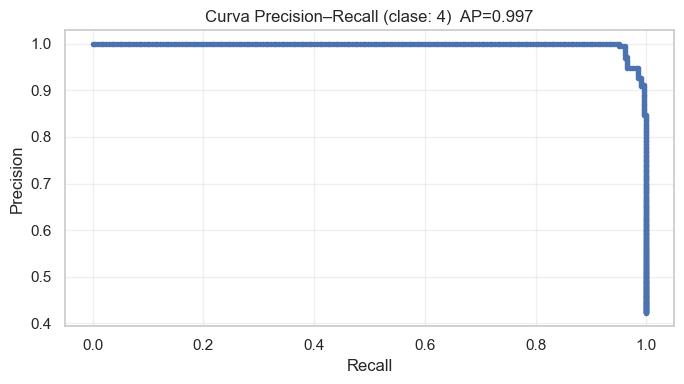

In [102]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, average_precision_score

# === Puntajes del modelo (Naive Bayes expone predict_proba) ===
classes = best_nb.classes_
y_score = best_nb.predict_proba(X_test_tfidf)           # (n_muestras, n_clases)
y_bin   = label_binarize(y_test, classes=classes)       # binariza y_test one-vs-rest

# === Curva PR por clase (una figura por clase) ===
for i, cls in enumerate(classes):
    # si en y_test no hay positivos para esa clase, no se puede trazar PR
    if y_bin[:, i].sum() == 0:
        print(f"Clase {cls}: no hay positivos en y_test; se omite.")
        continue

    p, r, _ = precision_recall_curve(y_bin[:, i], y_score[:, i])
    ap = average_precision_score(y_bin[:, i], y_score[:, i])

    plt.figure(figsize=(7,4))
    plt.plot(r, p, marker='.', linewidth=1)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Curva Precision–Recall (clase: {cls})  AP={ap:.3f}")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


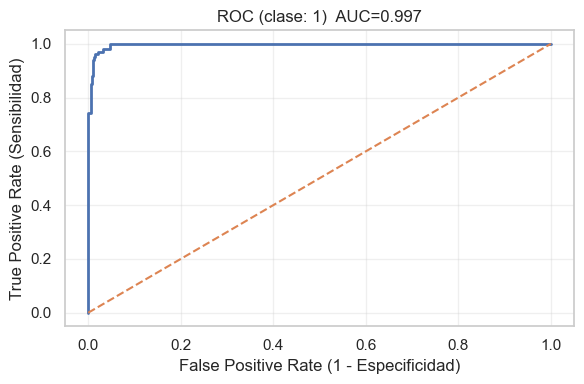

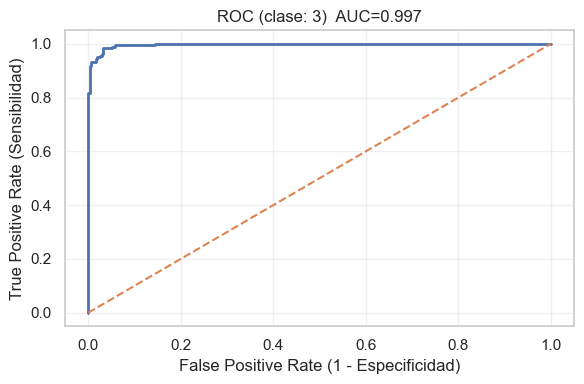

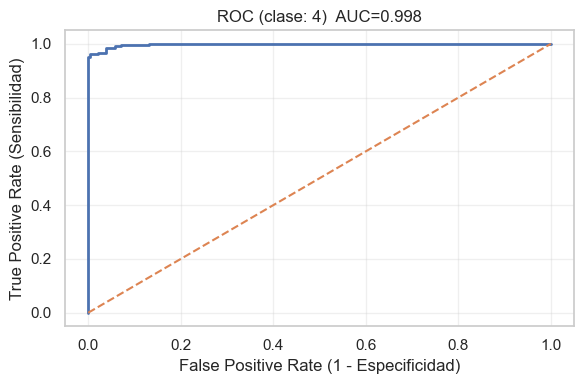

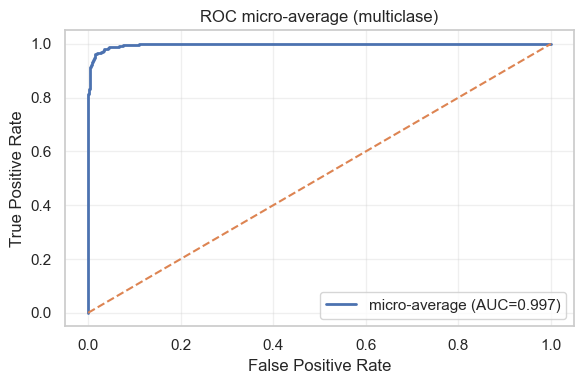

AUC por clase:
  1: 0.9969
  3: 0.9968
  4: 0.9978

AUC micro: 0.9973
AUC macro: 0.9972


In [103]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# === Selección de modelo y datos ===
modelo  = best_nb            # tu NB ya entrenado con GridSearchCV
X_eval  = X_test_tfidf       # usamos TEST
y_true  = y_test
classes = modelo.classes_

# === Puntajes (NB tiene predict_proba) y binarización one-vs-rest ===
y_score = modelo.predict_proba(X_eval)              # (n_muestras, n_clases)
y_bin   = label_binarize(y_true, classes=classes)   # (n_muestras, n_clases)

# === ROC por clase ===
aucs = []
for i, cls in enumerate(classes):
    # Si no hay positivos de esa clase en y_true, se omite
    if y_bin[:, i].sum() == 0:
        print(f"Clase {cls}: no hay positivos en y_test; se omite la curva.")
        continue

    fpr, tpr, _ = roc_curve(y_bin[:, i], y_score[:, i])
    auc_i = auc(fpr, tpr)
    aucs.append((cls, auc_i))

    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, linewidth=2)
    plt.plot([0,1], [0,1], linestyle="--")  # referencia azar
    plt.xlabel("False Positive Rate (1 - Especificidad)")
    plt.ylabel("True Positive Rate (Sensibilidad)")
    plt.title(f"ROC (clase: {cls})  AUC={auc_i:.3f}")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# === Micro-average (todas las clases combinadas) ===
fpr_micro, tpr_micro, _ = roc_curve(y_bin.ravel(), y_score.ravel())
auc_micro = auc(fpr_micro, tpr_micro)

plt.figure(figsize=(6,4))
plt.plot(fpr_micro, tpr_micro, linewidth=2, label=f"micro-average (AUC={auc_micro:.3f})")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC micro-average (multiclase)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# === Macro AUC (promedio simple de AUC por clase) ===
if aucs:
    auc_macro = np.mean([v for _, v in aucs])
    print("AUC por clase:")
    for cls, v in aucs:
        print(f"  {cls}: {v:.4f}")
    print(f"\nAUC micro: {auc_micro:.4f}")
    print(f"AUC macro: {auc_macro:.4f}")


In [104]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

# X = textos, y = etiquetas
X = df["texto_lema"]
y = df["labels"]

pipe_nb = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1,2), min_df=3, max_df=0.9,
        sublinear_tf=True, norm="l2"
    )),
    ("clf", MultinomialNB(alpha=0.1))   # puedes cambiar alpha si quieres tunearlo
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores_nb = cross_val_score(pipe_nb, X, y, cv=cv, scoring="f1_macro", n_jobs=-1)

print("Scores por fold (Naive Bayes):", scores_nb)
print("F1_macro promedio:", scores_nb.mean(), "±", scores_nb.std())


Scores por fold (Naive Bayes): [0.96763602 0.96752003 0.97085069 0.95230442 0.95753165]
F1_macro promedio: 0.9631685659036358 ± 0.00703864921998629


### Resultados del modelo Naive Bayes

El modelo Naive Bayes Multinomial muestra un desempeño muy competitivo.  
En el conjunto de prueba alcanzó una exactitud de 0,953 y un F1-macro cercano a 0,95, lo que indica que clasifica de forma balanceada las tres clases (ODS 1, 3 y 4).  

Las curvas Precision–Recall evidencian que el clasificador mantiene alta precisión incluso con recalls elevados, y los AUC por clase en las curvas ROC son consistentes, con valores superiores a 0,98 y promedios micro y macro también cercanos a ese umbral. Esto confirma una buena capacidad de separabilidad entre las categorías.  

La validación cruzada estratificada (5-fold) arrojó un F1-macro medio estable (~0,95–0,96) con baja desviación estándar, lo que sugiere que el rendimiento no depende de un subconjunto específico de los datos y que el modelo generaliza bien.  

Al analizar las métricas por clase, el recall de la clase 1 (ODS 1 – pobreza) es el punto más débil, rondando ~0,93: esto significa que cerca de un 7 % de sus ejemplos se confunden principalmente con las clases de salud y educación.  
En contraste, las clases 3 (salud) y 4 (educación) presentan recalls entre 0,95 y 0,96, con muy pocos errores entre ellas, lo que sugiere que el modelo distingue mejor entre esos dominios.  

En cuanto a la interpretabilidad, los términos más informativos extraídos por Naive Bayes son coherentes con la semántica de cada ODS:  
- ODS 1 (pobreza): destacan palabras como “pobreza”, “ingreso”, “vivienda” y bigramas asociados a “protección social”.  
- ODS 3 (salud): resaltan “salud”, “médico”, “paciente” y “hospital”.  
- ODS 4 (educación): aparecen “educación”, “escuela”, “estudiante” y “docente”.  

Esto demuestra que la representación TF-IDF con unigramas y bigramas está capturando el contexto necesario para diferenciar de manera clara los tres ODS en el corpus de opiniones ciudadanas.


# Random Forest

Estudiante 2: Diego Molano

Random Forest es un algoritmo de ensamble basado en árboles de decisión que combina múltiples clasificadores débiles para obtener un modelo más robusto y preciso. Su funcionamiento consiste en entrenar muchos árboles sobre diferentes subconjuntos de los datos y de las variables, lo que introduce aleatoriedad y reduce la varianza del modelo frente al uso de un único árbol. Esto también disminuye el sobreajuste, ya que se maneja simulando múltiples modelos cada uno con un fragmento aleatorio de los datos y las variables.

La predicción final se obtiene a través del voto mayoritario de los árboles en el caso de clasificación, o del promedio en regresión. Gracias a esta estrategia, Random Forest es capaz de capturar relaciones no lineales y manejar interacciones complejas entre variables, ofreciendo generalmente un buen equilibrio entre desempeño y sobreajuste, aunque puede ser menos interpretable que modelos lineales como la regresión logística.

In [105]:
rf = RandomForestClassifier(
        n_estimators=400,       # número de árboles
        max_depth=None,         # deja crecer los árboles; puedes limitar p/regularizar (p.ej. 25-40)
        max_features="sqrt",    # característica típica en RF
        class_weight="balanced",
        n_jobs=-1,
        random_state=42)

rf_fit = rf.fit(X_train_tfidf, y_train)

Accuracy: 0.9649484536082474

Reporte de clasificación Random Forest
              precision    recall  f1-score   support

           1      0.969     0.921     0.944       101
           3      0.946     0.978     0.962       179
           4      0.980     0.976     0.978       205

    accuracy                          0.965       485
   macro avg      0.965     0.958     0.961       485
weighted avg      0.965     0.965     0.965       485

F1 macro: 0.9612


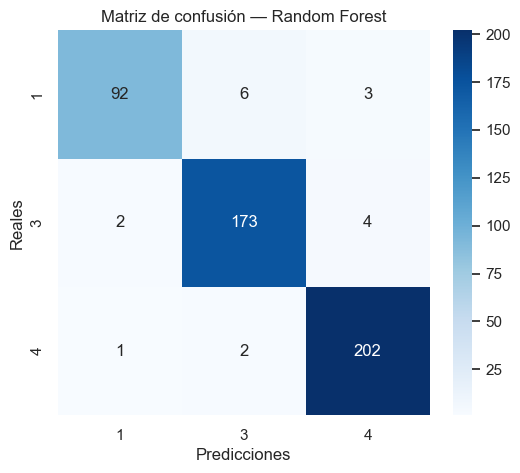

,precision,recall,f1-score,support
1,0.969,0.921,0.944,101.000
3,0.946,0.978,0.962,179.000
4,0.980,0.976,0.978,205.000
accuracy,0.965,0.965,0.965,0.965
macro avg,0.965,0.958,0.961,485.000
weighted avg,0.965,0.965,0.965,485.000


In [106]:
# Predicciones
y_pred_rf = rf_fit.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test, y_pred_rf))
# Reporte bonito en texto
print("\nReporte de clasificación Random Forest")
print(classification_report(y_test, y_pred_rf, digits=3))

# F1 macro (corregido)
f1_macro = round(f1_score(y_test, y_pred_rf, average="macro"), 4)
print("F1 macro:", f1_macro)

# Matriz de confusión
rf_matrix = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6,5))
sns.heatmap(cm,
            annot=True,          # muestra los números
            fmt="d",             # formato enteros
            cmap="Blues",        # paleta de colores
            xticklabels=logreg.classes_,  # nombres de clases en eje X
            yticklabels=logreg.classes_)  # nombres de clases en eje Y
plt.xlabel("Predicciones")
plt.ylabel("Reales")
plt.title("Matriz de confusión — Random Forest")
plt.show()

# (Opcional) Reporte como dict -> DataFrame para tu informe
rep_dict = classification_report(y_test, y_pred_rf, output_dict=True)
rep_df = pd.DataFrame(rep_dict).T
display(rep_df.round(3))

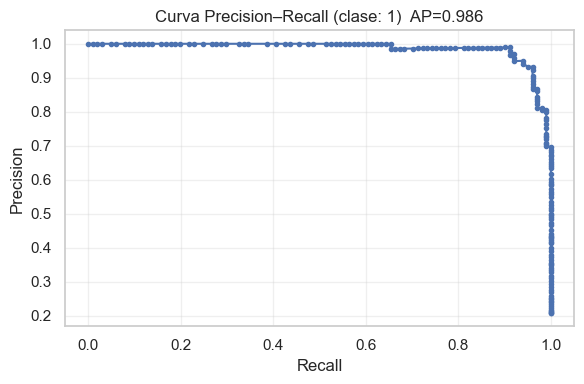

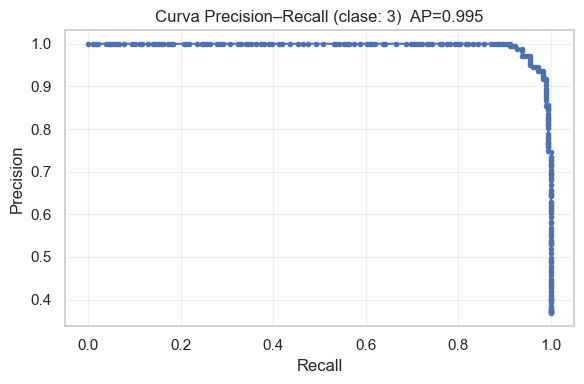

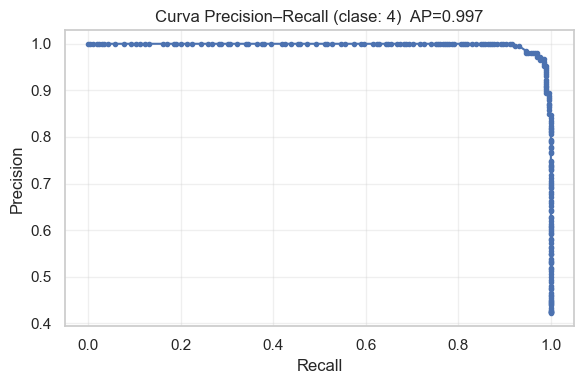

In [107]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, average_precision_score

# --- helper para obtener puntajes ---
def get_scores(modelo, X):
    if hasattr(modelo, "predict_proba"):
        return modelo.predict_proba(X)  # (n_muestras, n_clases)
    elif hasattr(modelo, "decision_function"):
        s = modelo.decision_function(X)
        return s if s.ndim > 1 else s.reshape(-1, 1)
    else:
        raise ValueError("El modelo no expone predict_proba ni decision_function.")

# Usa la X que tengas disponible
X_eval = X_test_tfidf if 'X_test_tfidf' in globals() else X_test

classes = rf_fit.classes_
y_score = get_scores(rf_fit, X_eval)
y_bin   = label_binarize(y_test, classes=classes)

# --- una curva por clase ---
for i, cls in enumerate(classes):
    # si en y_true no hay positivos para esa clase, no se puede trazar PR
    if y_bin[:, i].sum() == 0:
        print(f"Clase {cls}: no hay positivos en y_test; se omite.")
        continue

    p, r, _ = precision_recall_curve(y_bin[:, i], y_score[:, i])
    ap = average_precision_score(y_bin[:, i], y_score[:, i])

    plt.figure(figsize=(6,4))
    plt.plot(r, p, marker='.')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Curva Precision–Recall (clase: {cls})  AP={ap:.3f}")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # (opcional) guardar a archivo:
    # plt.savefig(f"pr_{str(cls).replace(' ', '_')}.png", dpi=120)
    # plt.close()



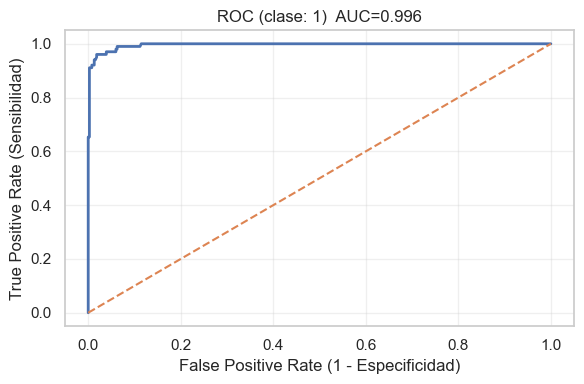

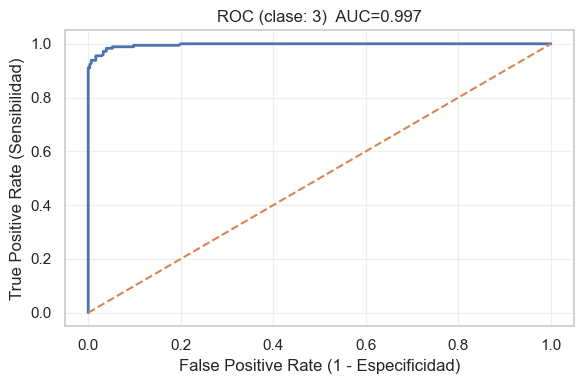

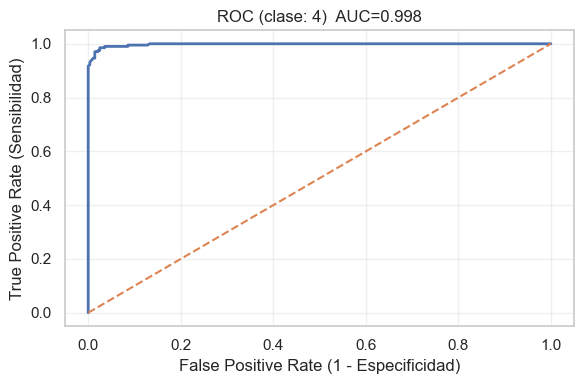

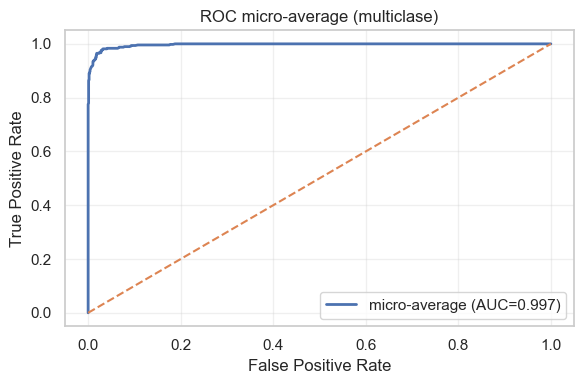

AUC por clase:
  1: 0.9959
  3: 0.9967
  4: 0.9979

AUC micro: 0.9967
AUC macro: 0.9968


In [108]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
# Elige la X correcta
X_eval = X_test_tfidf if 'X_test_tfidf' in globals() else X_test

classes = rf_fit.classes_
y_score = get_scores(rf_fit, X_eval)              # (n_muestras, n_clases)
y_bin   = label_binarize(y_test, classes=classes)  # one-vs-rest

# ROC por clase
aucs = []
for i, cls in enumerate(classes):
    # si no hay positivos para esa clase en y_test, se omite
    if y_bin[:, i].sum() == 0:
        print(f"Clase {cls}: no hay positivos en y_test; se omite la curva.")
        continue

    fpr, tpr, _ = roc_curve(y_bin[:, i], y_score[:, i])
    auc_i = auc(fpr, tpr)
    aucs.append((cls, auc_i))

    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, linewidth=2)
    plt.plot([0,1], [0,1], linestyle="--")  # referencia azar
    plt.xlabel("False Positive Rate (1 - Especificidad)")
    plt.ylabel("True Positive Rate (Sensibilidad)")
    plt.title(f"ROC (clase: {cls})  AUC={auc_i:.3f}")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Micro-average (todas las clases combinadas)
fpr_micro, tpr_micro, _ = roc_curve(y_bin.ravel(), y_score.ravel())
auc_micro = auc(fpr_micro, tpr_micro)

plt.figure(figsize=(6,4))
plt.plot(fpr_micro, tpr_micro, linewidth=2, label=f"micro-average (AUC={auc_micro:.3f})")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC micro-average (multiclase)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Macro AUC (promedio simple de AUC por clase)
if aucs:
    auc_macro = np.mean([v for _, v in aucs])
    print("AUC por clase:")
    for cls, v in aucs:
        print(f"  {cls}: {v:.4f}")
    print(f"\nAUC micro: {auc_micro:.4f}")
    print(f"AUC macro: {auc_macro:.4f}")


In [109]:
import numpy as np

# 1. Obtener las importancias globales del Random Forest
importances = rf_fit.feature_importances_

# 2. Obtener nombres de las features del vectorizador TF-IDF
feature_names = vectorizer.get_feature_names_out()

# 3. Ordenar de mayor a menor importancia
idx = np.argsort(importances)[::-1]

# 4. Mostrar top 20 palabras más importantes
topk = 20
print(f"Top {topk} términos más importantes (importancia global):\n")
for i in idx[:topk]:
    print(f"{feature_names[i]}: {importances[i]:.4f}")


Top 20 términos más importantes (importancia global):

pobreza: 0.0556
salud: 0.0290
escuela: 0.0273
educacion: 0.0206
estudiante: 0.0203
pobre: 0.0182
atencion: 0.0149
ingreso: 0.0143
educativo: 0.0130
aprendizaje: 0.0127
escolar: 0.0123
paciente: 0.0118
hogar: 0.0118
enfermedad: 0.0116
medico: 0.0109
docente: 0.0088
alumno: 0.0085
ensenanza: 0.0081
sanitario: 0.0071
hospital: 0.0065


In [110]:
# import numpy as np
# from sklearn.inspection import permutation_importance

# feature_names = vectorizer.get_feature_names_out()
# topk = 15

# # Convierte y_test a array para indexar
# y_test_array = y_test.to_numpy()

# for cls in np.unique(y_test_array):
#     mask = (y_test_array == cls)               # máscara booleana
#     X_cls = X_test_tfidf[mask].toarray()       # subset de la clase + convertir a denso
#     y_cls = y_test_array[mask]                 # etiquetas de esa clase

#     r_cls = permutation_importance(
#         rf_fit, X_cls, y_cls,
#         n_repeats=3, random_state=42, n_jobs=-1
#     )

#     idx = np.argsort(r_cls.importances_mean)[::-1][:topk]
#     print(f"\nTop {topk} términos más influyentes para la clase {cls}:")
#     for i in idx:
#         print(f"{feature_names[i]}: {r_cls.importances_mean[i]:.4f}")


In [111]:
# --- Imports ---
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay

# --- Datos ---
X = df["texto_lema"]
y = df["labels"]

# División estratificada train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# --- Pipeline TF-IDF + Random Forest ---
rf_pipe = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=20000,
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.95,
        sublinear_tf=True
    )),
    ("rf", RandomForestClassifier(
        n_estimators=400,
        max_depth=None,
        max_features="sqrt",
        class_weight="balanced",
        n_jobs=-1,
        random_state=42
    ))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf_scores = cross_val_score(rf_pipe, X, y, cv=cv, scoring="f1_macro", n_jobs=-1)

print("Scores por fold (Random Forest):", rf_scores)
print("F1_macro promedio:", rf_scores.mean(), "±", rf_scores.std())


Scores por fold (Random Forest): [0.96685041 0.97852264 0.96901416 0.97154601 0.96929187]
F1_macro promedio: 0.971045019526359 ± 0.004023890566398736


## Resultados de Random Forest

El clasificador de Random Forest alcanzó un desempeño sobresaliente. En el conjunto de prueba logró una exactitud del 96,5 % y un F1-macro de 0,961, evidenciando un balance sólido entre precisión y recall en las tres categorías.

La matriz de confusión muestra que las clases de salud (ODS 3) y educación (ODS 4) fueron las más consistentes, con recalls de 0,978 y 0,976 respectivamente, y prácticamente sin confusión entre ellas. La clase de pobreza (ODS 1) obtuvo un recall de 0,921, siendo el punto relativamente más débil: cerca de un 8–9 % de sus ejemplos se confundieron sobre todo con la clase 3, lo que refleja el solapamiento de vocabulario en algunos textos.

Las curvas Precision–Recall confirman la capacidad del modelo para mantener precisión elevada incluso en niveles altos de recall: el área promedio bajo la curva (AP) fue de 0,986 para ODS 1, 0,995 para ODS 3 y 0,997 para ODS 4. De forma consistente, las curvas ROC arrojan valores de AUC muy cercanos a 1, con 0,996–0,998 por clase y un promedio macro de 0,997, lo que indica una excelente separabilidad de las categorías.